In [1]:
import numpy as np
from scipy.interpolate import interp1d
import os

from pulse2percept import electrode2currentmap as e2cm
from pulse2percept import effectivecurrent2brightness as ec2b
from pulse2percept.utils import TimeSeries

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def find_file(datapath, startswith):
    # look for file in folder `datapath` that starts with `startswith`
    filename = ''
    for file in os.listdir(datapath):
        if file.startswith(startswith) and file.endswith('.npz'):
            filename = file
    
    return filename

In [3]:
def fit_amps(x, y, match_y):
    x = np.array(x)
    y = np.array(y)
    # We are given a list of input values `x` and their corresponding output values
    # `y` = f(x). We want to find the `x` value for which f(x) = `match_y`.

    # Easiest way is to use interp1d as x = f(y)!
    f = interp1d(y.flatten(), x.flatten(), fill_value='extrapolate')
    return np.asscalar(f(match_y))

In [4]:
def fit_gamma(x, y):
    x = np.array(x)
    y = np.array(y)
    # for all points (x,y), calculate r and compare to predicted
    best_err = np.inf
    best_gamma = 0
    for gamma in np.linspace(-2, 3, 100):
        err = np.sum(np.abs( np.sqrt(x**2 + y**2 + gamma * x * y) - 1))
        if err < best_err:
            best_err = err
            best_gamma = gamma
    return best_gamma

In [5]:
def movie2bright(pt, mode='max'):
    if mode == 'max':
        return pt.max()
    elif mode == 'softmax':
        # frame-wise softmax
        return (np.exp(pt) / np.exp(pt).sum(axis=(0,1))).max(axis=(0,1)).max()
    elif mode == 'mean':
        # frame-wise mean
        return pt.mean(axis=(0,1)).max()
    else:
        raise ValueError('Unknown mode "' + mode + '"')

In [6]:
def get_isobrightness(data, exp_params, mode='max', verbose=False):
    # This is the reference current that produces the reference brightness
    # we are trying to match
    amp_ref = exp_params['amp_ref']
    
    # Find reference brightness from single-electrode conditions
    # Condition 1
    x1 = data['cond1']['amp_E1'][0]
    match_b1 = movie2bright(data['cond1']['frames'][0].data, mode)
    
    # Condition 2
    x2 = data['cond2']['amp_E2'][0]
    match_b2 = movie2bright(data['cond2']['frames'][0].data, mode)
    
    if verbose:
        print(" - amp_ref=%f, match_b1=%f, match_b2=%f" % (amp_ref, match_b1, match_b2))
    
    gamma = []
    amp1 = []
    amp2 = []
    # For all other delays, compare delayed-pulse responses to match_b1 and match_b2
    for d in np.unique(data['cond3']['delay']):
        # indices where delay is d
        idx = np.where(data['cond3']['delay'] == d)[0]
        idx_start = idx[0]
        idx_end = idx[-1] + 1

        # From Condition 2 above
        plot_amp1 = [0]
        plot_amp2 = [1]

        # Condition 3
        x3 = data['cond3']['amp_E2'][idx_start:idx_end]
        y3 = [movie2bright(f.data, mode) for f in data['cond3']['frames'][idx_start:idx_end]]
        amp_b3 = fit_amps(x3, y3, match_b2)
        plot_amp1.append(data['cond3']['amp_E1'][2] / amp_ref)
        plot_amp2.append(amp_b3 / amp_ref)

        # Condition 5
        x5 = data['cond5']['amp_E1'][idx_start:idx_end]
        y5 = [movie2bright(f.data, mode) for f in data['cond5']['frames'][idx_start:idx_end]]
        amp_b5a = np.maximum(0, fit_amps(x5, y5, match_b1))
        plot_amp1.append(amp_b5a / amp_ref)
        x5 = data['cond5']['amp_E2'][idx_start:idx_end]
        y5 = [movie2bright(f.data, mode) for f in data['cond5']['frames'][idx_start:idx_end]]
        amp_b5b = np.maximum(0, fit_amps(x5, y5, match_b2))
        plot_amp2.append(amp_b5b / amp_ref)

        # Condition 4
        x4 = data['cond4']['amp_E1'][idx_start:idx_end]
        y4 = [movie2bright(f.data, mode) for f in data['cond4']['frames'][idx_start:idx_end]]
        amp_b4 = fit_amps(x4, y4, match_b1)
        plot_amp1.append(amp_b4 / amp_ref)
        plot_amp2.append(data['cond4']['amp_E2'][3] / amp_ref)

        # From Condition 1 above
        plot_amp1.append(1)
        plot_amp2.append(0)
        
        if verbose:
            print(" - amp_b3=%f" % amp_b3)
            print(" - amp_b4=%f" % amp_b4)
            print(" - amp_b5a=%f" % amp_b5a)
            print(" - amp_b5b=%f" % amp_b5b)
        
        g = fit_gamma(np.array(plot_amp1), np.array(plot_amp2))
        if g < -1 or g > 2:
            print(' - delay=%d: gamma=%f out of whack, clip' % (d, g))
            
            g = np.maximum(-1, np.minimum(2, g))
            
        gamma.append(g)
        amp1.append(plot_amp1)
        amp2.append(plot_amp2)
        
    return (amp1, amp2, gamma)

In [7]:
def plot_iso_fit(gamma, color='k', style='-', linewidth=2):
    x = np.linspace(0, 1, 100)
    y = 0.5 * (np.sqrt(gamma**2 * x**2 - 4 * x**2 + 4) - gamma * x)
    
    plt.plot(x, y, style, c=color, linewidth=linewidth)
    plt.plot(y, x, style, c=color, linewidth=linewidth)

In [8]:
def plot_isobrightness(amp_E1, amp_E2, gamma, delay, exp_params, save_fig=True, save_dir=''):
    from matplotlib.cm import gray as cmap
    
    pair = '(%s, %s)' % (exp_params['name_E1'], exp_params['name_E2'])
    plt.close()
    
    plt.fill_between([0, 1], [1, 1], color='lightgray', alpha=0.5)
    colors = [i / len(gamma) for i in range(len(gamma))]
    for e1, e2, c in zip(amp_E1, amp_E2, colors):
        plt.plot(e1, e2, 'o', color=cmap(c), label=0, linewidth=2)
    for g, c in zip(gamma, colors):
        plot_iso_fit(g, cmap(c))
    plot_iso_fit(-1, 'k', ':', 1)
    plot_iso_fit(0, 'k', ':', 1)
    plot_iso_fit(1, 'k', ':', 1)
    plot_iso_fit(2, 'k', ':', 1)
    plt.xlabel('E1')
    plt.ylabel('E2')
    plt.legend(loc='upper right')
    plt.title(pair)
    plt.axis([-0.2, 1.2, 0, 1.2])
    plt.axis('equal')
#     plt.legend(delay * 1000)
    plt.ylim(0, 1.2)
    plt.xlim(-0.2, 1.5)

    # These are in unitless fractions of the figure size. (0,0 is bottom left)
    left, bottom, width, height = [0.2, 0.2, 0.25, 0.25]
    ax2 = plt.axes([left, bottom, width, height])
    ax2.plot(gamma, 'o-k')
    ax2.plot([0, len(delay) - 1], [0, 0], ':k')
    ax2.plot([0, len(delay) - 1], [1, 1], ':k')
    plt.xticks(range(len(delay)), delay * 1000)
    plt.yticks([-1, 0, 1, 2])
    plt.xticks([])
    plt.ylim(-1, 2)
    
    
    if save_fig:
        if save_dir == '':
            save_dir = exp_params['save_dir']
        else:
            if not save_dir.endswith('/'):
                save_dir += '/'
        filename = '%s%s_%s_%s_%s_%.2fX_iso_%s' % (save_dir, 
                                                   exp_params['name'], 
                                                   exp_params['name_E1'], 
                                                   exp_params['name_E2'], 
                                                   exp_params['date'], 
                                                   exp_params['fac_thresh'],
                                                   mode)
        plt.savefig(filename + '.png')
        plt.savefig(filename + '.eps')
        print(' - Saved figure to %s.{eps,png}' % filename)

In [9]:
def plot_gamma(all_gamma, delay, mode, prefix='', save_fig=True, save_dir=''):
    all_gamma = np.array(all_gamma)
    x_min = np.minimum(-1, np.floor(all_gamma.min()))
    x_max = np.maximum(1, np.ceil(all_gamma.max()))
    plt.hist(all_gamma, stacked=True, label=delay * 1000, bins=11, range=(x_min, x_max))
    plt.xlabel('gamma')
    plt.ylabel('count')
    plt.legend()
    plt.title('movie2brightness: ' + mode)
    plt.ylim(0, 20)
    if save_fig:
        if save_dir == '':
            save_dir = exp_params['save_dir']
        else:
            if not save_dir.endswith('/'):
                save_dir += '/'
        filename = '%s%s%s_%s_%.2fX_gamma_%s' % (save_dir, 
                                                 prefix,
                                                 exp_params['name'],
                                                 exp_params['date'], 
                                                 exp_params['fac_thresh'],
                                                 mode)
        plt.savefig(filename + '.png')
        plt.savefig(filename + '.eps')
        print(' - Saved figure to %s.{eps,png}' % filename)

In [10]:
# Load Alan data
from scipy.io import loadmat

datapath = '../../data/Horsager_2011/'

alan_gamma = []
alan_labels = []

for file in os.listdir(datapath):
    if not file.startswith('S05_') and not file.startswith('S06'):
        continue
    if not file.endswith('.mat'):
        continue
    
    gamma = []
    A = loadmat(datapath + file)
    for x, y in zip(A['x'], A['y']):
        gamma.append(fit_gamma(x, y))
    alan_gamma.append(gamma)
    alan_labels.append(file[4:9])

(B3, B1):
 - Loading file TB-2009-03_B3_B1_2016-12-12_1.5X.npz
 - Saved figure to /home/mbeyeler/data/twopulse/lambda2.0_1.50X/TB-2009-03_B3_B1_2016-12-12_1.50X_iso_max.{eps,png}
(C3, B2):
 - Could not locate file "/home/mbeyeler/data/twopulse/lambda2.0_1.50X/TB-2009-03_C3_B2_*", skip
(A1, A4):
 - Loading file TB-2009-03_A1_A4_2016-12-12_1.5X.npz
 - Saved figure to /home/mbeyeler/data/twopulse/lambda2.0_1.50X/TB-2009-03_A1_A4_2016-12-12_1.50X_iso_max.{eps,png}
(C3, C2):
 - Could not locate file "/home/mbeyeler/data/twopulse/lambda2.0_1.50X/TB-2009-03_C3_C2_*", skip
(B2, B4):
 - Could not locate file "/home/mbeyeler/data/twopulse/lambda2.0_1.50X/TB-2009-03_B2_B4_*", skip
(B3, B2):
 - Could not locate file "/home/mbeyeler/data/twopulse/lambda2.0_1.50X/TB-2009-03_B3_B2_*", skip
(C1, B1):
 - Could not locate file "/home/mbeyeler/data/twopulse/lambda2.0_1.50X/TB-2009-03_C1_B1_*", skip
(A1, C1):
 - Loading file TB-2009-03_A1_C1_2016-12-12_1.5X.npz
 - Saved figure to /home/mbeyeler/data/twopu

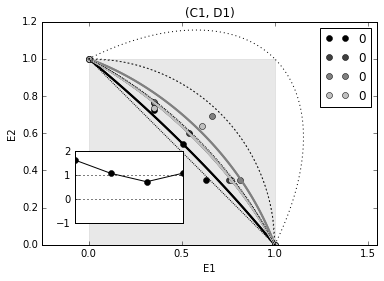

In [11]:
# Load simulated data

mode = 'max'
datapath = '/home/mbeyeler/data/twopulse/lambda2.0_1.50X/'
prefix = 'TB-2009-03'

# all S06 + S05
name_E1 = ['B3','C3','A1','C3','B2','B3','C1','A1','A4','C2','C4','A2',    'C3','C1','A1']
name_E2 = ['B1','B2','A4','C2','B4','B2','B1','C1','B4','B2','C1','C2',    'C2','D1','A2']

all_amp1 = []
all_amp2 = []
all_gamma = []
all_labels = []
for E1, E2 in zip(name_E1, name_E2):
    print('(%s, %s):' % (E1, E2))
    
    # Load data from file, auto-complete file name
    filestr = '%s_%s_%s_' % (prefix, E1, E2)
    filename = find_file(datapath, filestr)
    
    if filename == '':
        print(' - Could not locate file "' + datapath + filestr + '*", skip')
        continue
    else:
        print(' - Loading file ' + filename)

    exp_data = np.load(datapath + filename)
    data = exp_data['data'][()]
    exp_params = exp_data['exp_params'][()]
    
    # calculate isobrightness curve
    amp1, amp2, gamma = get_isobrightness(data, exp_params, mode=mode, verbose=False)
    all_amp1.append(amp1)
    all_amp2.append(amp2)
    all_gamma.append(gamma)
    all_labels.append(E1 + '_' + E2)
    
    # find delays from file specs
    delay = np.unique(data['cond3']['delay'])
    plot_isobrightness(amp1, amp2, gamma, delay, exp_params, save_dir=datapath)

 - Saved figure to /home/mbeyeler/data/twopulse/lambda2.0_1.50X/S05_S06TB-2009-03_2016-12-11_1.50X_gamma_max.{eps,png}


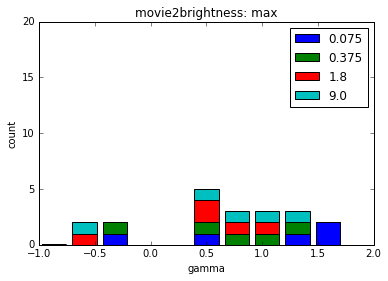

In [12]:
plot_gamma(all_gamma, delay, mode, prefix='S05_S06', save_dir=datapath)

 - Saved figure to /home/mbeyeler/data/twopulse/lambda2.0_1.50X/S05_S06TB-2009-03_2016-12-11_1.50X_gamma_max.{eps,png}


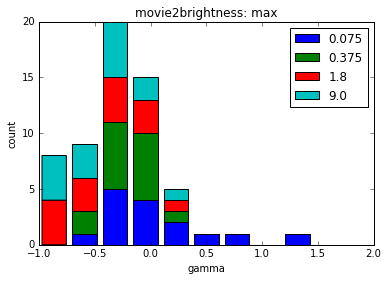

In [13]:
plot_gamma(alan_gamma, delay, mode, prefix='S05_S06', save_dir=datapath)

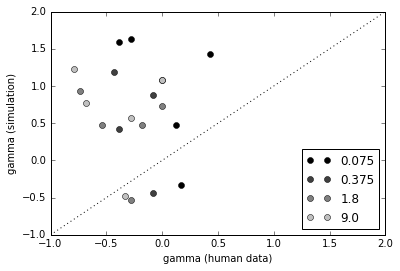

In [14]:
from matplotlib.cm import gray as cmap
    
colors = [i / len(all_gamma[0]) for i in range(len(all_gamma[0]))]

for i, label in enumerate(alan_labels):
    if label not in all_labels:
        continue
    j = all_labels.index(label)
    for ag, sg, c, d in zip(alan_gamma[i], all_gamma[j], colors, delay):
        if i == 0:
            plt.plot(ag, sg, 'o', color=cmap(c), label=d * 1000)
        else:
            plt.plot(ag, sg, 'o', color=cmap(c))
plt.plot([-1, 2], [-1, 2], 'k:')
plt.xlabel('gamma (human data)')
plt.ylabel('gamma (simulation)')
plt.legend(loc='lower right')
plt.savefig('scatter_humanvsmodel.eps')
plt.savefig('scatter_humanvsmodel.png')